In [5]:
from datetime import datetime, timedelta
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
def generate_date_list(start_date_str, end_date_str, interval_days=4):
    # Convert string inputs to dat|etime objects
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    
    # Generate list of dates
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    
    return date_list

In [6]:
def get_binance_ohlc_time(symbol, interval, start_str, end_str):
    print(start_str,"->",end_str)
    url = f'https://api.binance.com/api/v1/klines'
    
    # Convert start and end times to milliseconds since epoch
    start_ts = int(datetime.strptime(start_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    end_ts = int(datetime.strptime(end_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts
    }
    response = requests.get(url, params=params)
    data = response.json()
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])
        })
    
    df = pd.DataFrame(ohlc)
    df.reset_index(drop=True, inplace=True)

    # df.set_index('timestamp', inplace=True)
    return df

In [7]:

def is_pin_bar(candle):
    open_price = candle['open']
    close_price = candle['close']
    high_price = candle['high']
    low_price = candle['low']
    
    body_size = abs(close_price - open_price)
    upper_wick_size = high_price - max(open_price, close_price)
    candle_range = high_price - low_price
    
    # Define Pin Bar conditions
    long_tail = (upper_wick_size > 8 * body_size)
    small_body = body_size <= 0.2 * candle_range
    
    return long_tail and small_body

def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    dfcopy = df.copy()
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []
    dfcopy['fluct'] = (dfcopy['close'] - dfcopy['open']) / dfcopy['open'] * 100

    index_condition = []
    if model is None:
        index_condition = np.random.randint(100, len(df), num_random)
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.iloc[i-seq:i]
            x_array = x_array.values[:,1:].astype(np.float32)
            min_vol = np.min(x_array[:,-1])
            max_vol = np.max(x_array[:,-1])

            # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
            x_array[:,-1] = x_array[:,-1]/min_vol
            min_price = np.min(x_array[:,:4])
            max_price = np.max(x_array[:,:4])
            x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)


            x_array = np.array([x_array]).reshape(1, -1)
            dtest = xgb.DMatrix(x_array)
            y_pred_prob = int(model.predict(dtest)[0])
            # y_pred_prob2 = int(bst2.predict(dtest)[0])
            if y_pred_prob == 1:
                if manual_cond:
                    if dfcopy.iloc[i-1]['fluct'] <  0 or dfcopy.iloc[i-2]['fluct'] <  0 or is_pin_bar(df.iloc[i-1]):   # it nhat 1 nen do trong 2 nen truoc do
                        index_condition.append(i)
                else:
                    index_condition.append(i)
    index_condition = sorted(index_condition)
    for i in index_condition:
        a = df['open'].iloc[i]
        high_check = False
        low_check = False
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * a
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * a
            if high_check and low_check:
                print("check lai")
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < a:
                # print("win: ", df.iloc[j]['close'], df.iloc[i]['open'], money * (1 - df.iloc[j]['close'] / df.iloc[i]['open']))
                pnl = money * (1 - df.iloc[j]['close'] / df.iloc[i]['open'])
                balance += pnl
            else:
                # print("lose: ", df.iloc[j]['close'], df.iloc[i]['open'], -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1))
                pnl = -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "not", round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, index_condition, number_high, number_low, list_reward, prices_list

In [8]:
# start = "2024-09-19"
# end = "2024-09-24"
# list_day = generate_date_list(start, end, 4)
# list_day.append(end)
# df_all = []
# symb = "ORDIUSDT"
# interval = "15m"
# for i in range(len(list_day)-1):
#     df = get_binance_ohlc_time(symb, interval, list_day[i]+" 00:15:00", list_day[i+1]+" 00:00:00")
#     df_all.append(df)
# df_all = pd.concat(df_all,ignore_index=True, axis=0)
# csv_file = f"data_his/{symb}_{start}_{end}_{interval}.csv"
# df_all.to_csv(csv_file, index=False)
# df_all = pd.read_csv(csv_file)
df_all = pd.read_csv("data_his/ORDIUSDT_2023-06-12_2024-08-11_15m.csv")
df_all

,timestamp,open,high,low,close,volumn
0,2023-11-07 19:00:00,5.905,11.800,5.905,10.000,1840312.07
1,2023-11-07 19:15:00,9.992,10.500,9.985,10.358,531244.05
2,2023-11-07 19:30:00,10.358,10.579,10.193,10.299,358515.14
3,2023-11-07 19:45:00,10.299,10.579,10.291,10.565,182173.50
4,2023-11-07 20:00:00,10.560,10.899,10.381,10.403,258017.98
...,...,...,...,...,...,...
26512,2024-08-09 23:00:00,27.360,27.570,27.250,27.570,10533.58
26513,2024-08-09 23:15:00,27.560,27.750,27.480,27.660,5692.05
26514,2024-08-09 23:30:00,27.660,27.750,27.600,27.620,4437.74
26515,2024-08-09 23:45:00,27.610,27.670,27.480,27.670,6915.32


In [9]:
df = df_all.iloc[:15000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3, num_random=10000)


,timestamp,open,high,low,close,volumn
0,2023-11-07 19:00:00,5.905,11.8,5.905,10.0,1840312.07


,timestamp,open,high,low,close,volumn
14998,2024-04-12 00:30:00,71.639,71.672,71.264,71.394,10341.35
14999,2024-04-12 00:45:00,71.395,71.461,71.000,71.030,15166.52


check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
num points:  10000 number_low/all_point 0.488 cannot_break 5924


In [11]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        
        min_vol = np.min(x_array[:,-1])
        max_vol = np.max(x_array[:,-1])
        if min_vol == 0:
            continue

        x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
        # x_array[:,-1] = x_array[:,-1]/min_vol

        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)

        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
    return x, y




In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
num_samples = 1000
sequence_length = 50
num_features = 5
num_classes = 3
batch_size = 32
num_epochs = 2
learning_rate = 0.001


# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Generate sample data
X, y = create_dataset(df_all, rs, sequence_length)
# print(X.shape, y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(num_features, 64, 2, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Sample predictions
model.eval()
with torch.no_grad():
    sample_X, sample_y = next(iter(test_loader))
    sample_X, sample_y = sample_X.to(device), sample_y.to(device)
    outputs = model(sample_X)
    _, predicted = torch.max(outputs.data, 1)
    
    print("\nSample predictions:")
    for i in range(5):
        print(f"Sample {i+1}: True class: {sample_y[i].item()}, Predicted class: {predicted[i].item()}")

Epoch [1/2], Loss: 0.6883
Epoch [2/2], Loss: 0.9257
Test Accuracy: 59.09%

Sample predictions:
Sample 1: True class: 2, Predicted class: 0
Sample 2: True class: 1, Predicted class: 0
Sample 3: True class: 0, Predicted class: 0
Sample 4: True class: 0, Predicted class: 0
Sample 5: True class: 0, Predicted class: 0


In [15]:
outputs.shape

torch.Size([32, 3])

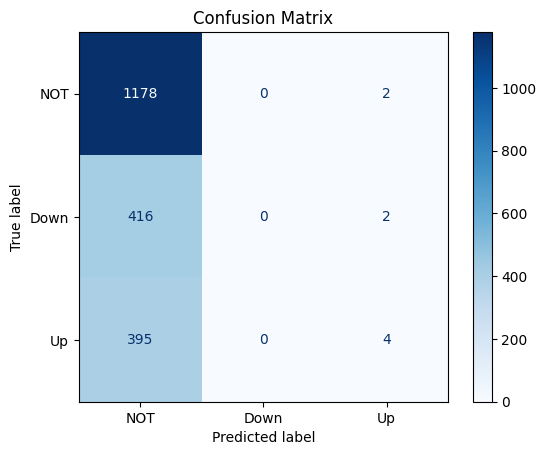

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for prices, labels in test_loader:
        outputs = model(prices).squeeze()
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=["NOT", 'Down', 'Up'])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()